<a href="https://colab.research.google.com/github/mattdiep15/projects/blob/main/Amazon_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Overview

This project explores a dataset containing over 1,500 Amazon product listings containing information on prices, discounts, ratings, and other insights. The objectives of this project include uncovering meaningful insights across the variables to answer key questions about pricing trends, quality, and product performance. Once the data is cleaned and prepared, a series of visualizations are performed to uncover patterns and validate our assumptions about the data.


## The Dataset

The [inital dataset](https://www.kaggle.com/datasets/karkavelrajaj/amazon-sales-dataset) was sourced from Kaggle and additional synthetic data was generated to expand the volume of product listings. The following columns are included in the dataset and will be used throughout the analysis:

**product_name:** Title of product as listed on Amazon \
**category:** Product category (e.g. Computers & Accessories, Office Products) \
**discounted_price:** Price after discount \
**original_price:** Original listed price \
**discount_percentage:** Percentage reduction between original and final price \
**rating:** Average customer rating (1-5) \
**rating_count:** Number of customer reviews for product \
**review_title:** Title of customer review

## Python Libraries

**pandas** – for data cleaning, transformation, and analysis \
**seaborn** – for data visualization \
**re** – for regular expressions and text preprocessing


In [76]:
# importing useful libraries and connecting to drive
import pandas as pd
import seaborn as sns
from google.colab import drive
import re
drive.mount('/content/drive')

print('setup complete')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
setup complete


In [77]:
# DATA CLEANING
df = pd.read_csv('/content/drive/My Drive/Datasets/amazon_dataset.csv')

# splits original category variable into main category
category_split = df['category'].str.split('|')
df['category'] = category_split.str[0]

# Selects a subset of columns for analysis
df = df[['product_name', 'category', 'discounted_price',
       'actual_price', 'discount_percentage', 'rating', 'rating_count',
         'review_title'
        ]]

In [78]:
# Replaces the rupee symbol and commas to make the entry a float
exchange_rate = 83
df['discounted_price'] = df['discounted_price'].str.replace('₹', '').str.replace(',', '').astype(float)
df['actual_price'] = df['actual_price'].str.replace('₹', '').str.replace(',', '').astype(float)

# converts the price into dollars
df['discounted_price'] = (df['discounted_price'] / exchange_rate).round(2)
df['actual_price'] = (df['actual_price'] / exchange_rate).round(2)

# renames actual_price -> original_price
df = df.rename(columns={'actual_price': 'original_price'})

# converts discount_percentage and rating_count entries into float
df['discount_percentage'] = df['discount_percentage'].str.replace('%', '').astype(float)
df['rating_count'] = df['rating_count'].str.replace('|', '').str.replace(',', '').astype(float)

df.head()

,product_id,product_name,category,discounted_price,original_price,discount_percentage,rating,rating_count,review_title
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories,4.81,13.24,64.0,4.2,24269.0,"Satisfied,Charging is really fast,Value for mo..."
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories,2.40,4.20,43.0,4,43994.0,"A Good Braided Cable for Your Type C Device,Go..."
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories,2.40,22.88,90.0,3.9,7928.0,"Good speed for earlier versions,Good Product,W..."
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories,3.96,8.42,53.0,4.2,94363.0,"Good product,Good one,Nice,Really nice product..."
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories,1.86,4.81,61.0,4.2,16905.0,"As good as original,Decent,Good one for second..."


## 1) What product categories have the highest discount percentage?

<ipython-input-79-508de7ec77b4>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


(0.0, 65.0)

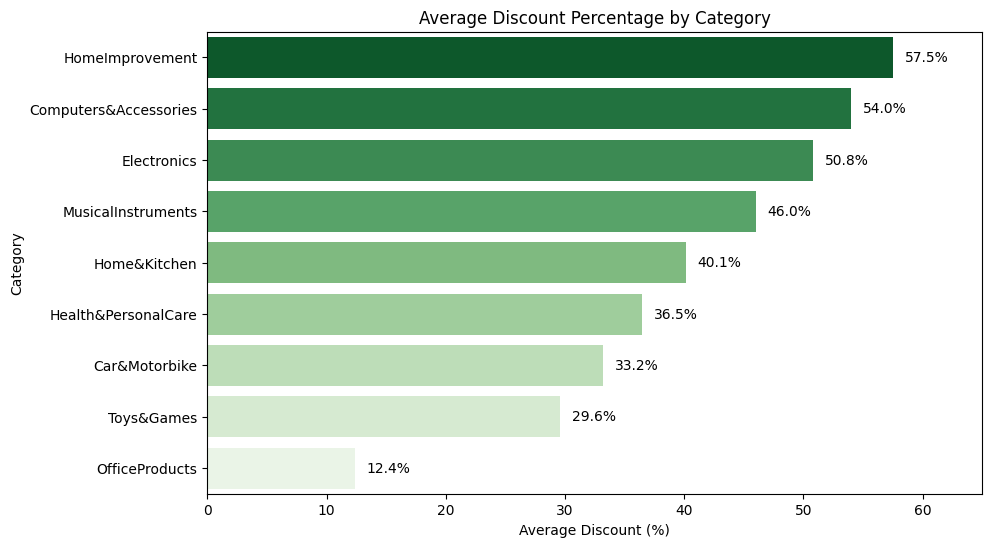

In [79]:
discount_by_category = df.groupby('category')['discount_percentage'].mean() \
                       .reset_index() \
                       .sort_values('discount_percentage', ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=discount_by_category,
    x='discount_percentage',
    y='category',
    palette='Greens_r'
)

plt.title('Average Discount Percentage by Category')
plt.xlabel('Average Discount (%)')
plt.ylabel('Category')

# text labels to the bars
for i in ax.patches:
    ax.text(
        i.get_width() + 1,
        i.get_y() + i.get_height() / 2,
        f'{i.get_width():.1f}%',
        va='center'
    )

# increasing x axis limit so homeimprovement percentage fits screen
plt.xlim(right=65)

The Home Improvement category showed the highest average discount percentage of 57.5 followed by the Computer & Accessories (54.0%) and the Electronics (50.8%). Having the second and third highest categories based off of discount percentage be both technologically reliant, it is possible that rapid product cycles with fast improving technology, pushes older inventory to be discounted more heavily.

## 2) Do products with higher discounts receive better or worse ratings?

Text(0, 0.5, 'Ratings')

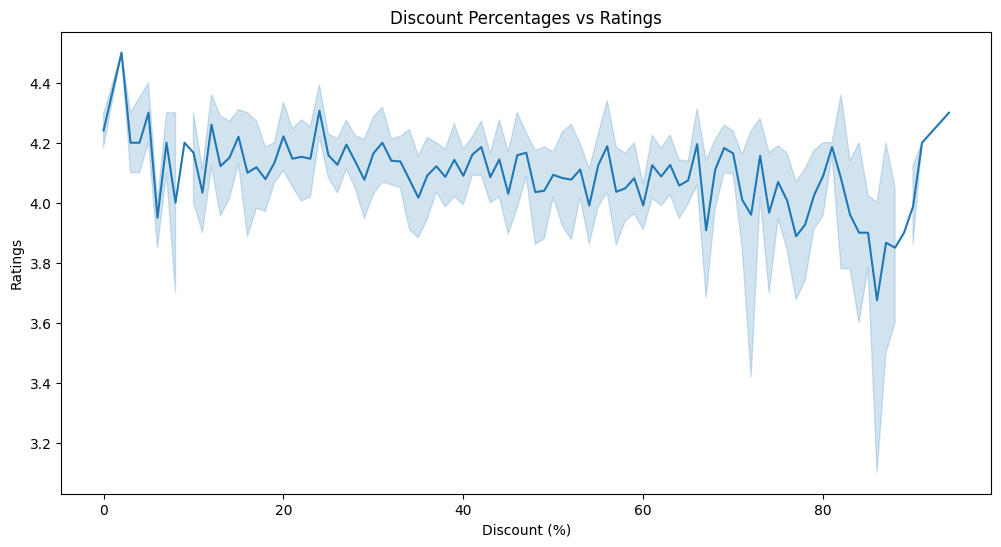

In [140]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data= df,
    x= 'discount_percentage',
    y= 'rating',
    )

# Annotations
plt.title('Discount Percentages vs Ratings')
plt.xlabel('Discount (%)')
plt.ylabel('Ratings')

There is a very slight downwards relationship between the two variables. From a logistical standpoint, we should expect some sort of negative relationship between discount percentage and ratings. Lower-rated products are often more aggressively discounted, to make them more appealing to consumers. In other words, sellers could be trying to offset lower reviews with better deals.

## 3) Which categories have the most consistent product quality

Text(0, 0.5, 'Category')

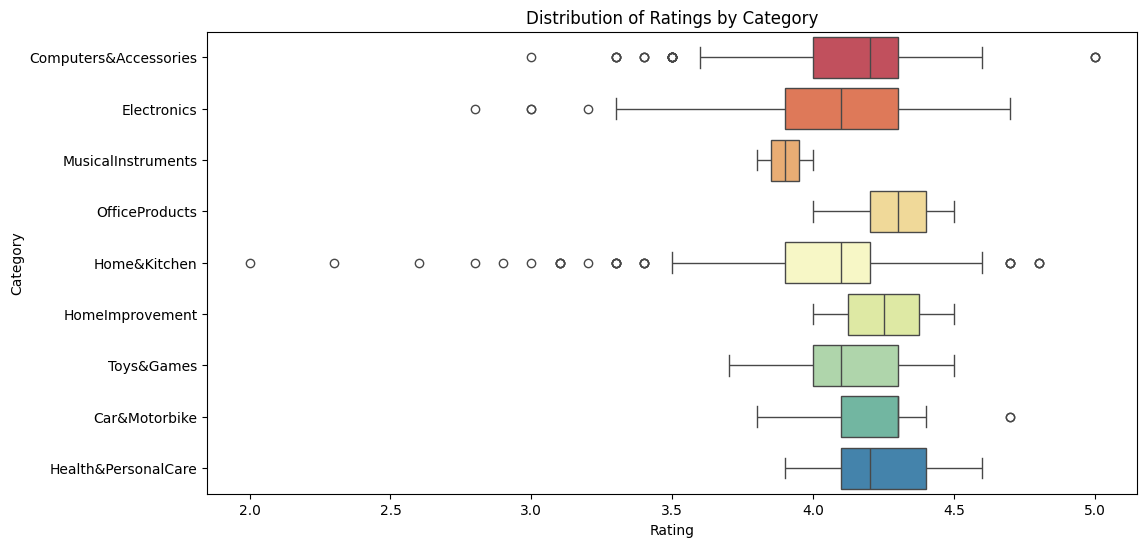

In [149]:
df['rating'] = pd.to_numeric(df['rating'], errors= 'coerce')
filtered_df = df.dropna(subset=['rating'])

plt.figure(figsize=(12, 6))
sns.boxplot(
    data= filtered_df,
    x= 'rating',
    y= 'category',
    hue= 'category',
    palette='Spectral'
    )

# Annotations
plt.title('Distribution of Ratings by Category')
plt.xlabel('Rating')
plt.ylabel('Category')

The Home & Kitchen category has the largest spread of ratings, ranging from 2.0 to 4.6, followed by Computers & Accessories and Electronics categories. It is possible given that Home & Kitchen covering everything from kitchen towels to appliances naturally leads to a larger distribution of quality. Computer accessories and electronics vary greatly in performance as these categories oftern feature lesser-known knockoff brands along top-tier ones such as Apple, Sony, Logitech.

## 4) Which category has the largest range of prices?

In [155]:
price_range = df.groupby('category')['original_price'].agg(['min', 'max']).reset_index()
price_range['range'] = price_range['max'] - price_range['min']
price_range = price_range.sort_values('range', ascending=False)
price_range.head()

,category,min,max,range
2,Electronics,2.06,1685.54,1683.48
4,Home&Kitchen,0.95,915.54,914.59
1,Computers&Accessories,0.47,721.57,721.10
0,Car&Motorbike,4.18,48.19,44.01
7,OfficeProducts,0.60,36.13,35.53


<ipython-input-152-f816af9c2b9e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


Text(0, 0.5, 'Category')

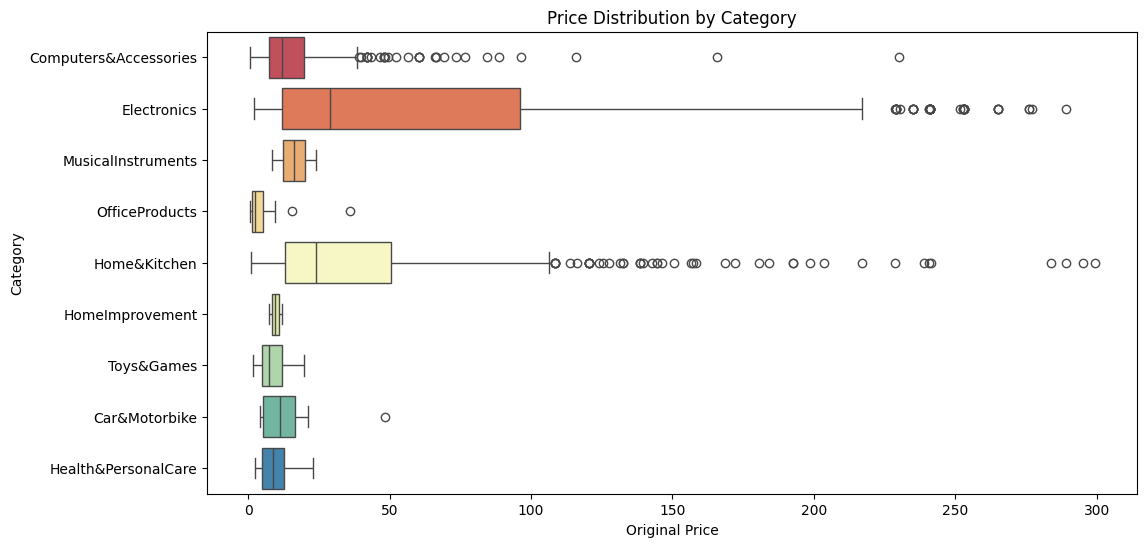

In [152]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df[df['original_price'] <= 300],
    y='category',
    x='original_price',
    palette='Spectral'
)

# Annotations
plt.title('Price Distribution by Category')
plt.xlabel('Original Price')
plt.ylabel('Category')


The electronics category by far has the largest distribution of prices and range. This category includes a wide range of products from cheap usb cables to luxury smart TVs and laptops.

## 5) Which keywords appear most frequently in product names?

<ipython-input-137-c538e0af1067>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


Text(0, 0.5, 'Keyword')

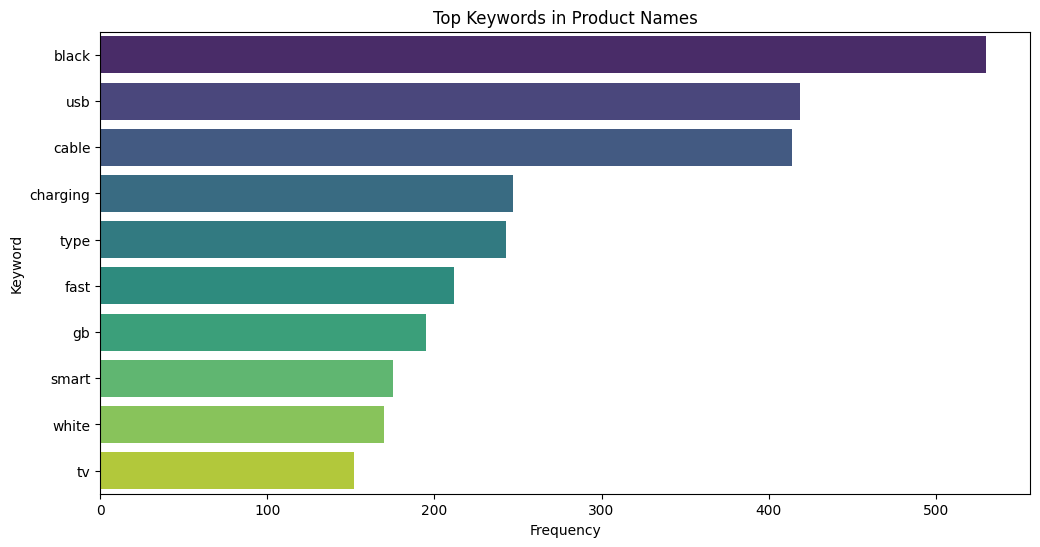

In [137]:
# Removes special characters
review_keywords = df['product_name'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', ' ', x.lower()) if isinstance(x, str) else '')
review_keywords = review_keywords.str.split()

# Iterates through each sublist and adds words to a list
all_keywords = [word for sublist in review_keywords for word in sublist]

# Filtering out common keywords of no importance
unecessary = {'the', 'and', 'for', 'with', 'a', 'this', 'is', 'of', 'to', 'it', 'my', 'on', 'but', 'c' ,'w', 's', 'in', 'm'}
review_keywords = [word for word in all_keywords if word not in unecessary]

keyword_counts = Counter(review_keywords)
keyword_df = pd.DataFrame(keyword_counts.most_common(10), columns=['keyword', 'count'])

plt.figure(figsize=(12, 6))
sns.barplot(
    data=keyword_df,
    x='count',
    y='keyword',
    palette='viridis'
)

# Annotations
plt.title('Top Keywords in Product Names')
plt.xlabel('Frequency')
plt.ylabel('Keyword')

Black is the most common keyword in listings within this dataset, followed by usb and cable. These three words suggests an emphasis on products centered around connectivity and charging. Black being the most common word is also the most common product color of electronics and also potentially signifies the dataset being heavily populated by practical, functional items.

# Conclusion

The primary objective of this project was to explore the Amazon Sales dataset and uncover insights through exploratory data analysis (EDA). This data set is a rich source of information for understanding customer behavior, product performance and other relationships. Analyzing these patterns in pricing, ratings, and product categories can inform future product strategies and marketing improvements.

## Skills Demonstrated:
Data Cleaning \
Preprocessing \
Exploratory Data Analysis \
Data Visualization \
Python